# Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from keras.layers import LSTM
from keras.layers import Embedding


from sklearn.model_selection import train_test_split

import nltk 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

2022-05-04 03:02:37.773012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 03:02:37.773050: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 4.4 MB/s eta 0:00:01


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/patidar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
glove_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
!wget 'https://nlp.stanford.edu/data/glove.6B.zip'
!unzip "glove.6B.zip" -d "glove"

# Importing Dataset

In [10]:
dataset = pd.read_excel("IMDB.xlsx")
dataset.head()

,URL,Text,Sentiment
0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS
1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS
2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS
3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS
4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS


# Understanding the Dataset

In [11]:
dataset.shape

(1999, 3)

In [12]:
dataset['Sentiment'].value_counts()

NEG    1000
POS     999
Name: Sentiment, dtype: int64

# Data Pre-processing

In [13]:
reviews = dataset['Text']
reviews.shape

(1999,)

### 1. For TfIdf vectorizer

In [14]:
def dataPreprocessingTfIdf(data):
    
    corpus = []
    
    stop_words = set(stopwords.words('english'))
    url_patterns = re.compile(r'https?://\S+|www\.\S+')
    for x in range(data.shape[0]):
        
        statement = url_patterns.sub(r'',data[x])
        statement = re.sub('[^a-zA-Z]', ' ', statement)
        statement = statement.lower() 
        statement = statement.split()
        
        ps = PorterStemmer()
        statement = [ps.stem(word) for word in statement if not word in stop_words]
        for i in statement:
            corpus.append(i)

    return corpus

In [15]:
X_preprocessed_tfidf = dataPreprocessingTfIdf(reviews)

### 2. For Bert Embeddings

In [16]:
def dataPreprocessingBert(data):
    corpus = []
    
    stop_words = set(stopwords.words('english'))
    url_patterns = re.compile(r'https?://\S+|www\.\S+')
    
    for x in range(data.shape[0]):
        statement = url_patterns.sub(r'',data[x])
        statement = re.sub('[^a-zA-Z]', ' ', statement) 
        statement = statement.lower()
        statement = statement.split()
        
        ps = PorterStemmer()
        statement = [ps.stem(word) for word in statement if not word in stop_words] # Stemming the dataset and removing stopwords
        statement = ' '.join(statement)
        corpus.append(statement)
        
    return corpus

In [17]:
# X_preprocessed_bert = dataPreprocessingBert(reviews)

### 3. Glove Embedding

In [19]:
emmbed_dict = {}
with open('./glove/glove.6B.200d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        emmbed_dict[word]=vector
emmbed_dict['oov'] = np.zeros(200)

In [20]:
def dataPreprocessingGlove(data):
    
    corpus = []
   
    stop_words = set(stopwords.words('english'))
    url_patterns = re.compile(r'https?://\S+|www\.\S+')
    
    
    for x in range(data.shape[0]):
        statement = url_patterns.sub(r'',data[x])
        statement = re.sub('[^a-zA-Z]', ' ', statement) 
        statement = statement.lower() 
        statement = word_tokenize(statement)

        embed_statement = []
        for w in statement:
            if w in emmbed_dict:
                embed_statement.append(emmbed_dict[w])
            else:
                embed_statement.append(emmbed_dict['oov'])
        corpus.append(embed_statement)
    
    return np.array(corpus)

In [21]:
X_preprocessed_glove = dataPreprocessingGlove(reviews)

/tmp/ipykernel_39174/2203086893.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(corpus)


### Pre-processing Label

In [22]:
temp = dataset['Sentiment']
y = []
for i in temp:
    if i=='POS':
        y.append(1)
    else:
        y.append(0)

# Create the Embeddings

### 1. Tf-idf Vectorizer

In [23]:
vectorizer = TfidfVectorizer(max_features = 5000)
vectorizer.fit(X_preprocessed_tfidf)

TfidfVectorizer(max_features=5000)

In [24]:
X_tfidf = vectorizer.transform(reviews)
X_tfidf[0]

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 29 stored elements in Compressed Sparse Row format>

### 2. BERT Embeddings

In [ ]:
# X_bert = []
# for i in X_preprocessed_bert:
#     embed = bert_model.encode(i)
#     X_bert.append(embed)
# np.save('bert_embeddings_2000.npy', np.array(X_bert))

In [26]:
X_bert = np.load('bert_embeddings_2000.npy')
X_bert.shape

(1999, 768)

### 3. Glove Embeddings

In [27]:
X_glove = np.zeros((X_preprocessed_glove.shape[0], 100, 200))
for i in range(X_glove.shape[0]):
    embedding = np.array(X_preprocessed_glove[i][0])
    X_glove[i,0:embedding.shape[0],:] = embedding

In [28]:
X_glove.shape

(1999, 100, 200)

# Split the data into train and test set

### 1. TF-IDF embeddings

In [29]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size = 0.3)

### 2. BERT embeddings

In [30]:
y_bert = np.array(y)

In [31]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y_bert, test_size = 0.3)

### 3. Glove embeddings

In [32]:
y_glove = np.array(y)

In [33]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y_glove, test_size = 0.3)

# Create models

### 1. SVM

In [34]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train_tfidf, y_train_tfidf) 

SVC()

### 2. Multinomial Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB
MNB_model = MultinomialNB()
MNB_model.fit(X_train_tfidf, y_train_tfidf) 

MultinomialNB()

### 3. Bernoulli Naive Bayes

In [36]:
from sklearn.naive_bayes import BernoulliNB
BNB_model = BernoulliNB()
BNB_model.fit(X_train_tfidf, y_train_tfidf) 

BernoulliNB()

### 4. Decision Tree Classifier

In [37]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train_tfidf, y_train_tfidf) 

DecisionTreeClassifier()

### 5. Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
LR_model.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression()

### 6. Multi-Layer Perceptron Classifier

In [39]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier()
mlp_model.fit(X_train_bert, y_train_bert)

/home/patidar/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

### 7. Multi-Layer Neural Network

In [40]:
mlp_model2 = Sequential()
mlp_model2.add(Dense(1024, activation = 'relu'))
mlp_model2.add(Dense(512, activation = 'relu'))
mlp_model2.add(Dense(1, activation = 'sigmoid'))
mlp_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
mlp_model2.fit(X_train_bert, y_train_bert , validation_data = (X_test_bert, y_test_bert), epochs=10)

2022-05-04 03:16:56.459415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-04 03:16:56.459549: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-04 03:16:56.459636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Sourabh-Ubuntu): /proc/driver/nvidia/version does not exist
2022-05-04 03:16:56.504039: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
44/44 [==============================] - 2s 17ms/step - loss: 0.5826 - accuracy: 0.7062 - val_loss: 0.4945 - val_accuracy: 0.7567
Epoch 2/10
44/44 [==============================] - 0s 10ms/step - loss: 0.4619 - accuracy: 0.7827 - val_loss: 0.5699 - val_accuracy: 0.7417
Epoch 3/10
44/44 [==============================] - 0s 10ms/step - loss: 0.4501 - accuracy: 0.7913 - val_loss: 0.5111 - val_accuracy: 0.7667
Epoch 4/10
44/44 [==============================] - 0s 9ms/step - loss: 0.4232 - accuracy: 0.8034 - val_loss: 0.5444 - val_accuracy: 0.7483
Epoch 5/10
44/44 [==============================] - 0s 10ms/step - loss: 0.4246 - accuracy: 0.7934 - val_loss: 0.5729 - val_accuracy: 0.7383
Epoch 6/10
44/44 [==============================] - 0s 10ms/step - loss: 0.4005 - accuracy: 0.8084 - val_loss: 0.5193 - val_accuracy: 0.7517
Epoch 7/10
44/44 [==============================] - 0s 10ms/step - loss: 0.3508 - accuracy: 0.8385 - val_loss: 0.5569 - val_accuracy: 0.7517
Epoch 8/10
44/

### 8. LSTM 

In [41]:
lstm_model = Sequential()
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_glove, y_train_glove , validation_data = (X_test_glove, y_test_glove), epochs=10)

Epoch 1/10


2022-05-04 03:17:06.890849: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 111920000 exceeds 10% of free system memory.


43/44 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5371

2022-05-04 03:17:10.676273: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.


44/44 [==============================] - 4s 47ms/step - loss: 0.6941 - accuracy: 0.5368 - val_loss: 0.6824 - val_accuracy: 0.5833
Epoch 2/10
44/44 [==============================] - 2s 36ms/step - loss: 0.6611 - accuracy: 0.5926 - val_loss: 0.6792 - val_accuracy: 0.5783
Epoch 3/10
44/44 [==============================] - 2s 35ms/step - loss: 0.6368 - accuracy: 0.6247 - val_loss: 0.6875 - val_accuracy: 0.5683
Epoch 4/10
44/44 [==============================] - 2s 36ms/step - loss: 0.6082 - accuracy: 0.6490 - val_loss: 0.7109 - val_accuracy: 0.5433
Epoch 5/10
44/44 [==============================] - 2s 36ms/step - loss: 0.5850 - accuracy: 0.6569 - val_loss: 0.7200 - val_accuracy: 0.5733
Epoch 6/10
44/44 [==============================] - 2s 37ms/step - loss: 0.5633 - accuracy: 0.6662 - val_loss: 0.7486 - val_accuracy: 0.5667
Epoch 7/10
44/44 [==============================] - 2s 36ms/step - loss: 0.5564 - accuracy: 0.6669 - val_loss: 0.7619 - val_accuracy: 0.5467
Epoch 8/10
44/44 [======

# Evaluation Metrics

In [47]:
accuracies = []
confusion_matrices = []
f1scores = []
recalls = []
precisions = []
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    for i in range(len(y_pred)):
        if y_pred[i]>0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    accuracies.append(accuracy_score(y_test, y_pred)*100)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    f1scores.append(f1_score(y_test, y_pred)*100)
    recalls.append(recall_score(y_test, y_pred)*100)
    precisions.append(precision_score(y_test, y_pred)*100)

In [48]:
evaluate(MNB_model, X_test_tfidf, y_test_tfidf)
evaluate(BNB_model, X_test_tfidf, y_test_tfidf)
evaluate(svc_model, X_test_tfidf, y_test_tfidf)
evaluate(LR_model, X_test_tfidf, y_test_tfidf)
evaluate(DT_model, X_test_tfidf, y_test_tfidf)
evaluate(mlp_model, X_test_bert, y_test_bert)
evaluate(mlp_model2, X_test_bert, y_test_bert)
evaluate(lstm_model, X_test_glove, y_test_glove)

2022-05-04 03:17:57.345769: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 48000000 exceeds 10% of free system memory.


In [50]:
models = ["MultinomialNB",  "BernoulliNB", "SVM", "LogisiticRegression","DecisionTree", "MLP","MLP2","LSTM"]
n_models = 8
l = np.arange(n_models)

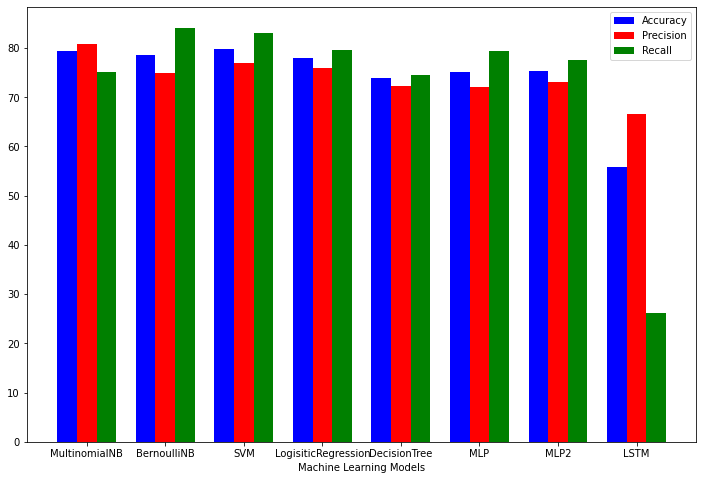

In [51]:
fig = plt.subplots(figsize =(12, 8))
plt.bar(l, accuracies, width = 0.25, color = 'b', label="Accuracy")
plt.bar(l+0.25, precisions, width = 0.25, color='red', label="Precision")
plt.bar(l+0.5, recalls, width= 0.25, color ='g', label = "Recall")
plt.xticks([r + 0.25 for r in range(n_models)],models)
plt.xlabel("Machine Learning Models")
plt.legend()
plt.show()

In [52]:
for i in range(n_models):
    cv = confusion_matrices[i]
    print(" | ", models[i], " | ", cv[0][0]," | ", cv[0][1]," | ",cv[1][1]," | ", cv[1][0], " | ")

 |  MultinomialNB  |  258  |  52  |  218  |  72  | 
 |  BernoulliNB  |  228  |  82  |  244  |  46  | 
 |  SVM  |  238  |  72  |  241  |  49  | 
 |  LogisiticRegression  |  237  |  73  |  231  |  59  | 
 |  DecisionTree  |  227  |  83  |  216  |  74  | 
 |  MLP  |  221  |  89  |  230  |  60  | 
 |  MLP2  |  227  |  83  |  225  |  65  | 
 |  LSTM  |  255  |  40  |  80  |  225  | 


| Method | U | V | X | Y |
| --- | --- | --- | --- | --- |
 |  MultinomialNB  |  258  |  52  |  218  |  72  | 
 |  BernoulliNB  |  228  |  82  |  244  |  46  | 
 |  SVM  |  238  |  72  |  241  |  49  | 
 |  LogisiticRegression  |  237  |  73  |  231  |  59  | 
 |  DecisionTree  |  227  |  83  |  216  |  74  | 
 |  MLP  |  221  |  89  |  230  |  60  | 
 |  MLP2  |  227  |  83  |  225  |  65  | 
 |  LSTM  |  255  |  40  |  80  |  225  |

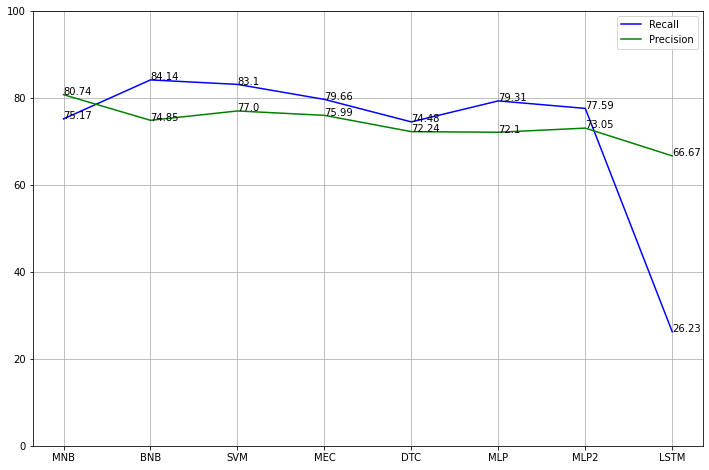

In [53]:
fig = plt.subplots(figsize =(12, 8))
models = ["MNB", "BNB", "SVM","MEC", "DTC", "MLP","MLP2", "LSTM"]
plt.plot(models, recalls, color = 'blue', label = "Recall")
plt.plot(models, precisions , color='green', label = "Precision")
for a,b in zip(models, recalls): 
    plt.text(a, b, str(round(b,2)))
for a,b in zip(models, precisions): 
    plt.text(a, b, str(round(b,2)))
plt.ylim(0,100)
plt.grid()
plt.legend()
plt.show()

In [54]:
models = ["MultinomialNB",  "BernoulliNB", "SVM", "LogisiticRegression","DecisionTree", "MLP","MLP2","LSTM"]
for i in range(8):
    print(" | ", models[i]," | ", round(accuracies[i],2),"% | ", round(precisions[i],2), "% | ", round(recalls[i],2), "% | ", round(f1scores[i],2), "% | ")

 |  MultinomialNB  |  79.33 % |  80.74 % |  75.17 % |  77.86 % | 
 |  BernoulliNB  |  78.67 % |  74.85 % |  84.14 % |  79.22 % | 
 |  SVM  |  79.83 % |  77.0 % |  83.1 % |  79.93 % | 
 |  LogisiticRegression  |  78.0 % |  75.99 % |  79.66 % |  77.78 % | 
 |  DecisionTree  |  73.83 % |  72.24 % |  74.48 % |  73.34 % | 
 |  MLP  |  75.17 % |  72.1 % |  79.31 % |  75.53 % | 
 |  MLP2  |  75.33 % |  73.05 % |  77.59 % |  75.25 % | 
 |  LSTM  |  55.83 % |  66.67 % |  26.23 % |  37.65 % | 


| Method | Accuracy | Precision | Recall | F1-score |
| --- | --- | --- | --- | --- |
|  MultinomialNB  |  78.83 % |  74.29 % |  83.57 % |  78.66 % | 
 |  BernoulliNB  |  81.33 % |  76.09 % |  87.5 % |  81.4 % | 
 |  SVM  |  78.5 % |  72.95 % |  85.71 % |  78.82 % | 
 |  LogisiticRegression  |  77.5 % |  72.31 % |  83.93 % |  77.69 % | 
 |  DecisionTree  |  71.33 % |  66.77 % |  76.79 % |  71.43 % | 
 |  MLP  |  76.67 % |  74.68 % |  78.77 % |  76.67 % | 
 |  MLP2  |  73.33 % |  69.88 % |  79.45 % |  74.36 % | 
 |  LSTM  |  55.83 % |  59.35 % |  41.64 % |  48.94 % | 